<h2><font color="#004D7F" size=6>Módulo Extra. Preprocesamiento y Tratamiento de datos</font></h2>



<h1><font color="#004D7F" size=5>4. Reducción de dimensionalidad con SVD</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

---

<h2><font color="#004D7F" size=5>Índice</font></h2>
<a id="indice"></a>

* [1. Introducción](#section1)
    * [1.1. SVD](#section11)
    * [1.2. Librerías](#section12)
    * [1.3. Conjunto de datos](#section12)
* [2. SVD como reducción de dimensiones](#section2)
    * [2.1. Aplicación de SVD](#section21)
    * [2.2. Optimización de SVD](#section22)
    * [2.3. SVD en Forecasting](#section23)

In [1]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:98% }</style>"))

---
<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>

La reducción del número de variables de entrada para un modelo predictivo se denomina reducción de dimensionalidad. Menos variables de entrada pueden resultar en un modelo predictivo más simple que puede tener un mejor rendimiento al hacer predicciones sobre nuevos datos.

Quizás la técnica más popular para la reducción de la dimensionalidad es el análisis de componentes principales (PCA, por sus siglas del inglés) aunque se tiene otra técnica que también es tanto o más popular, esta es, Descomposición de Valores Singulares (SVD, por sus siglas del inglés). Esta es una técnica que proviene del campo del álgebra lineal y se puede utilizar como técnica de preparación de datos para crear una proyección de un conjunto de datos antes de ajustar un modelo.

 <a id="section11"></a>
 ## <font color="#004D7F"> 1.1. SVD</font>

Podemos considerar las variables o características (columnas) representan dimensiones en un espacio de características *n*-dimensionales y las filas de datos como puntos en ese espacio. Ésta es una interpretación geométrica útil de un conjunto de datos.

Tener una gran cantidad de dimensiones en el espacio de características puede significar que el volumen de ese espacio es muy grande y, a su vez, los puntos que tenemos en ese espacio (filas de datos) a menudo representan una muestra pequeña y no representativa. A menudo es deseable reducir el número de características de entrada. Esto reduce el número de dimensiones del espacio de características, de ahí el nombre "madición de dimensionalidad".

Un enfoque popular para la reducción de dimensionalidad es utilizar técnicas del campo del álgebra lineal . Esto a menudo se denomina "proyección de características" y los algoritmos utilizados se denominan "métodos de proyección". Los métodos de proyección buscan reducir el número de dimensiones en el espacio de características y al mismo tiempo preservar la estructura o las relaciones más importantes entre las variables observadas en los datos.

El conjunto de datos resultante, la proyección, se puede utilizar como entrada para entrenar un modelo de ML. En esencia, las características originales ya no existen y las nuevas características se construyen a partir de los datos disponibles que no son directamente comparables con los datos originales. Cualquier dato nuevo que se envíe al modelo en el futuro al realizar predicciones también debe proyectarse utilizando la misma técnica.

SVD podría ser la técnica más popular para la reducción de dimensionalidad cuando los datos son escasos.

Los datos dispersos se refieren a filas de datos donde muchos de los valores son cero. Este suele ser el caso en algunos dominios problemáticos, como los sistemas de recomendación, donde un usuario tiene una calificación para muy pocas películas o canciones en la base de datos y una calificación cero para todos los demás casos. Otro ejemplo común es un modelo de bolsa de palabras de un documento de texto, donde el documento tiene un recuento o frecuencia para algunas palabras y la mayoría de las palabras tienen un valor 0. SVD es una buena técnica para estos casos.

Ejemplos de datos escasos apropiados para aplicar SVD para la reducción de dimensionalidad:
* Sistemas de recomendación
* Compras de productos de cliente
* Contar canciones que escucha un usuario
* Clasificaciones de películas
* Clasificación de texto
* One-Hot Encoding
* TF/IDF

Se puede pensar en SVD como un método de proyección en el que los datos con m columnas (características) se proyectan en un subespacio con m columnas o menos, mientras se conserva la esencia de los datos originales. SVD se usa ampliamente tanto en el cálculo de otras operaciones matriciales, como la matriz inversa, como también como método de reducción de datos en el aprendizaje automático.

<a id="section11"></a>
## <font color="#004D7F"> 1.1. Librerías</font>

Por último vamos a declarar algunas librerías generales que ya hemos estado trabajando y que usaremos a lo largo de la sección. 

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import collections as co
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Conjunto de datos</font>

Para este ejemplo vamos a usar la función [`make_classification()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) y así crear un problema de clasificación binaria sintética con 1,000 ejemplos y 20 características de entrada, 15 de las cuales son significativas.

In [3]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
print(X.shape, y.shape)

(1000, 20) (1000,)


<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section2"></a>
# <font color="#004D7F"> 2. SVD como reducción de dimensiones</font>

La librería scikit-learn proporciona la clase [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) que puede encajar en un conjunto de datos y usarse para transformar un conjunto de datos de entrenamiento y cualquier conjunto de datos adicional en el futuro.

<a id="section21"></a>
## <font color="#004D7F"> 2.1. Aplicación de SVD</font>

La SVD se utiliza normalmente en datos escasos. Esto incluye datos para un sistema de recomendación o un modelo de contar de palabras para texto. Si los datos son densos, entonces es mejor utilizar el método PCA .

Usaremos un Pipeline donde el primer paso realiza la transformación SVD y selecciona las 10 componentes más importantes, luego ajusta un modelo de regresión logística en estas características. 

En este caso, podemos ver que la transformada SVD con regresión logística logró un rendimiento de alrededor del 81,4%.

**Nota**: No necesitamos normalizar las variables en este conjunto de datos, ya que todas las variables tienen la misma escala por diseño.

In [5]:
steps = [('svd', TruncatedSVD(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.814 (0.034)


<a id="section22"></a>
## <font color="#004D7F"> 2.2. Optimización de SVD</font>

Si nos fijamos hemos elegido de forma arbitraria el valor de 10 componentes pero no sabemos si esos componenetes son los óptimos para conseguir los mejores resultados. 

Un mejor enfoque es evaluar la misma transformación y modelo con diferentes números de características de entrada y elegir la cantidad de características (cantidad de reducción de dimensionalidad) que resulte en el mejor rendimiento promedio.

>1 0.542 (0.046)
>2 0.626 (0.050)
>3 0.719 (0.053)
>4 0.722 (0.052)
>5 0.721 (0.054)
>6 0.729 (0.045)
>7 0.802 (0.034)
>8 0.800 (0.040)
>9 0.814 (0.037)
>10 0.814 (0.034)
>11 0.817 (0.037)
>12 0.820 (0.038)
>13 0.820 (0.036)
>14 0.825 (0.036)
>15 0.865 (0.027)
>16 0.865 (0.027)
>17 0.865 (0.027)
>18 0.865 (0.027)
>19 0.865 (0.027)


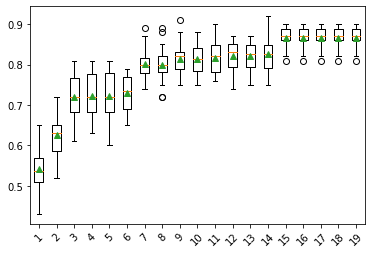

In [7]:
# Obtener el dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y

# Obtener la lista de modelos
def get_models():
    models = dict()
    for i in range(1,20):
        steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models

# Método de entrenamiento
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


X, y = get_dataset()

models = get_models()

# Evaluamos los resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# Visualizamos resultados
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

## Análisis de los resultados

Vemos una tendencia general de mayor rendimiento a medida que aumenta el número de dimensiones hasta que este converge en 15 componentes. Esto coincide con nuestra definición del problema donde solo los primeros 15 componentes contienen información sobre la clase y los cinco restantes son redundantes.

<a id="section23"></a>
## <font color="#004D7F"> 2.3. SVD en Forecasting</font>

Podemos optar por utilizar una combinación de modelo de regresión logística y SVD como nuestro modelo final.

Esto implica ajustar el Pipeline en todos los datos disponibles y usar este para hacer predicciones sobre nuevos datos. Es importante destacar que se debe realizar la misma transformación en estos nuevos datos, que se manejan automáticamente a través de Pipeline.

El siguiente ejemplo proporciona un ejemplo de ajuste y uso de un modelo final con transformaciones de SVD en nuevos datos.

In [8]:
steps = [('svd', TruncatedSVD(n_components=15)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# Ajuste del modelo
model.fit(X, y)
# Hacer una predicción simple
row = [[0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]]
yhat = model.predict(row)
print('Clase predicha: %d' % yhat[0])

Clase predicha: 1


<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>